In [20]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
#from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 15})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [7, 5]
#from IPython.display import Audio, display
#def allDone():
#    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
#import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#import emcee
import corner
#import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
#from multiprocessing import Pool
#import pickle
#import h5py
#import multiprocessing
#import itertools
#from multiprocessing import sharedctypes
print('imported')
import scipy

imported


In [21]:
import pandas as pd

In [22]:
import keras.backend as K

In [23]:
import tensorflow as tf

In [82]:
from keras.models import Sequential,Model
from keras.layers import Dense,Input
from keras.optimizers import Adam, Adamax, SGD
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

In [25]:
## Enter parameter:
searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

1040

In [26]:
modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in tqdm(filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

100%|██████████| 1040/1040 [00:05<00:00, 179.39it/s]


In [64]:
X = np.stack((teffs,loggs)).transpose()
t = np.log(modelspectra)

sc = MinMaxScaler()
msc = StandardScaler()

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t)

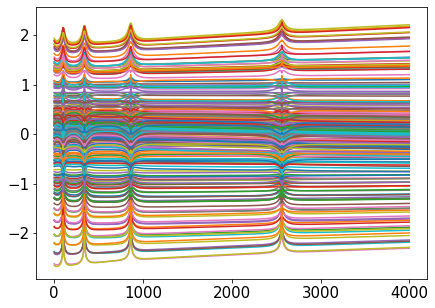

In [65]:
plt.plot(t_scaled[0:205].T);

In [91]:
H = 128
def generator():
    x = Input(shape=(X[0].shape[0],))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deep.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_93 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_94 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_95 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_96 (Dense)             (None, 4000)              516000    
Total params: 565,920
Trainable params: 565,920
Non-trainable params: 0
_________________________________________________________________
None

In [ ]:
for i in tqdm(range(1000)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 100
    batch = 32
    
    h = model.fit(X_scaled,t_scaled, epochs = n_epochs, verbose = 0, batch_size = batch, shuffle = True)
    history = np.append(history, h.history['loss'])
    model.save_weights('model_interp_deep.h5')
















  0%|          | 0/1000 [00:00<?, ?it/s]

Training meta-batch 0

















  0%|          | 1/1000 [00:23<6:33:19, 23.62s/it]

Training meta-batch 1

















  0%|          | 2/1000 [00:39<5:55:34, 21.38s/it]

Training meta-batch 2

















  0%|          | 3/1000 [00:59<5:45:59, 20.82s/it]

Training meta-batch 3

















  0%|          | 4/1000 [01:28<6:26:28, 23.28s/it]

Training meta-batch 4

















  0%|          | 5/1000 [02:02<7:21:32, 26.63s/it]

Training meta-batch 5

















  1%|          | 6/1000 [02:37<8:00:56, 29.03s/it]

Training meta-batch 6

















  1%|          | 7/1000 [03:11<8:28:11, 30.71s/it]

Training meta-batch 7

















  1%|          | 8/1000 [03:46<8:47:39, 31.91s/it]

Training meta-batch 8

















  1%|          | 9/1000 [04:21<8:59:57, 32.69s/it]

Training meta-batch 9

















  1%|          | 10/1000 [04:55<9:09:09, 33.28s/it]

Training meta-batch 10

















  1%|          | 11/1000 [05:30<9:14:32, 33.64s/it]

Training meta-batch 11

















  1%|          | 12/1000 [06:04<9:18:33, 33.92s/it]

Training meta-batch 12

















  1%|▏         | 13/1000 [06:39<9:22:34, 34.20s/it]

Training meta-batch 13

















  1%|▏         | 14/1000 [07:14<9:24:29, 34.35s/it]

Training meta-batch 14

















  2%|▏         | 15/1000 [07:49<9:24:58, 34.41s/it]

Training meta-batch 15

















  2%|▏         | 16/1000 [08:23<9:26:07, 34.52s/it]

Training meta-batch 16

















  2%|▏         | 17/1000 [08:58<9:25:37, 34.52s/it]

Training meta-batch 17

















  2%|▏         | 18/1000 [09:33<9:26:06, 34.59s/it]

Training meta-batch 18

















  2%|▏         | 19/1000 [10:07<9:26:45, 34.66s/it]

Training meta-batch 19

















  2%|▏         | 20/1000 [10:42<9:25:27, 34.62s/it]

Training meta-batch 20

















  2%|▏         | 21/1000 [11:17<9:25:11, 34.64s/it]

Training meta-batch 21

















  2%|▏         | 22/1000 [11:51<9:24:31, 34.63s/it]

Training meta-batch 22

















  2%|▏         | 23/1000 [12:26<9:23:45, 34.62s/it]

Training meta-batch 23

















  2%|▏         | 24/1000 [13:01<9:24:55, 34.73s/it]

Training meta-batch 24

















  2%|▎         | 25/1000 [13:35<9:24:00, 34.71s/it]

Training meta-batch 25

















  3%|▎         | 26/1000 [14:10<9:23:53, 34.74s/it]

Training meta-batch 26

















  3%|▎         | 27/1000 [14:45<9:23:54, 34.77s/it]

Training meta-batch 27

















  3%|▎         | 28/1000 [15:20<9:22:51, 34.74s/it]

Training meta-batch 28

















  3%|▎         | 29/1000 [15:55<9:22:36, 34.77s/it]

Training meta-batch 29

















  3%|▎         | 30/1000 [16:29<9:21:33, 34.74s/it]

Training meta-batch 30

















  3%|▎         | 31/1000 [17:04<9:19:54, 34.67s/it]

Training meta-batch 31

















  3%|▎         | 32/1000 [17:38<9:18:39, 34.63s/it]

Training meta-batch 32

















  3%|▎         | 33/1000 [18:13<9:18:24, 34.65s/it]

Training meta-batch 33

















  3%|▎         | 34/1000 [18:48<9:18:25, 34.68s/it]

Training meta-batch 34

















  4%|▎         | 35/1000 [19:22<9:17:43, 34.68s/it]

Training meta-batch 35

















  4%|▎         | 36/1000 [19:57<9:15:42, 34.59s/it]

Training meta-batch 36

















  4%|▎         | 37/1000 [20:31<9:14:42, 34.56s/it]

Training meta-batch 37

















  4%|▍         | 38/1000 [21:06<9:15:11, 34.63s/it]

Training meta-batch 38

















  4%|▍         | 39/1000 [21:41<9:14:31, 34.62s/it]

Training meta-batch 39

















  4%|▍         | 40/1000 [22:15<9:14:01, 34.63s/it]

Training meta-batch 40

















  4%|▍         | 41/1000 [22:50<9:14:07, 34.67s/it]

Training meta-batch 41

















  4%|▍         | 42/1000 [23:25<9:13:22, 34.66s/it]

Training meta-batch 42

















  4%|▍         | 43/1000 [24:00<9:13:35, 34.71s/it]

Training meta-batch 43

















  4%|▍         | 44/1000 [24:34<9:13:21, 34.73s/it]

Training meta-batch 44

















  4%|▍         | 45/1000 [25:09<9:12:34, 34.72s/it]

Training meta-batch 45

















  5%|▍         | 46/1000 [25:44<9:11:38, 34.69s/it]

Training meta-batch 46

















  5%|▍         | 47/1000 [26:18<9:11:16, 34.71s/it]

Training meta-batch 47

















  5%|▍         | 48/1000 [26:53<9:09:30, 34.63s/it]

Training meta-batch 48

















  5%|▍         | 49/1000 [27:27<9:08:38, 34.62s/it]

Training meta-batch 49

















  5%|▌         | 50/1000 [28:02<9:06:13, 34.50s/it]

Training meta-batch 50

















  5%|▌         | 51/1000 [28:36<9:06:29, 34.55s/it]

Training meta-batch 51

















  5%|▌         | 52/1000 [29:11<9:06:20, 34.58s/it]

Training meta-batch 52

















  5%|▌         | 53/1000 [29:46<9:05:43, 34.58s/it]

Training meta-batch 53

















  5%|▌         | 54/1000 [30:20<9:05:33, 34.60s/it]

Training meta-batch 54

















  6%|▌         | 55/1000 [30:55<9:05:03, 34.61s/it]

Training meta-batch 55

















  6%|▌         | 56/1000 [31:30<9:05:01, 34.64s/it]

Training meta-batch 56

















  6%|▌         | 57/1000 [32:04<9:04:30, 34.65s/it]

Training meta-batch 57

















  6%|▌         | 58/1000 [32:39<9:04:15, 34.67s/it]

Training meta-batch 58

















  6%|▌         | 59/1000 [33:14<9:04:22, 34.71s/it]

Training meta-batch 59

















  6%|▌         | 60/1000 [33:48<9:02:33, 34.63s/it]

Training meta-batch 60

















  6%|▌         | 61/1000 [34:23<9:02:47, 34.68s/it]

Training meta-batch 61

















  6%|▌         | 62/1000 [34:58<9:02:07, 34.68s/it]

Training meta-batch 62

















  6%|▋         | 63/1000 [35:32<9:00:44, 34.63s/it]

Training meta-batch 63

















  6%|▋         | 64/1000 [36:07<9:01:48, 34.73s/it]

Training meta-batch 64

















  6%|▋         | 65/1000 [36:42<8:59:28, 34.62s/it]

Training meta-batch 65

















  7%|▋         | 66/1000 [37:16<9:00:18, 34.71s/it]

Training meta-batch 66

















  7%|▋         | 67/1000 [37:51<8:59:36, 34.70s/it]

Training meta-batch 67

















  7%|▋         | 68/1000 [38:26<8:58:23, 34.66s/it]

Training meta-batch 68

















  7%|▋         | 69/1000 [39:00<8:56:52, 34.60s/it]

Training meta-batch 69

















  7%|▋         | 70/1000 [39:35<8:56:02, 34.58s/it]

Training meta-batch 70

















  7%|▋         | 71/1000 [40:09<8:56:12, 34.63s/it]

Training meta-batch 71

















  7%|▋         | 72/1000 [40:44<8:56:06, 34.66s/it]

Training meta-batch 72

















  7%|▋         | 73/1000 [41:19<8:55:31, 34.66s/it]

Training meta-batch 73

















  7%|▋         | 74/1000 [41:54<8:54:49, 34.65s/it]

Training meta-batch 74


100.000 percent improvement


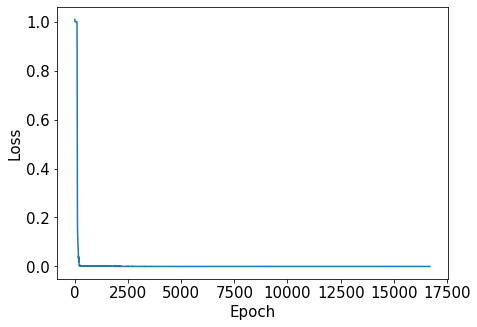

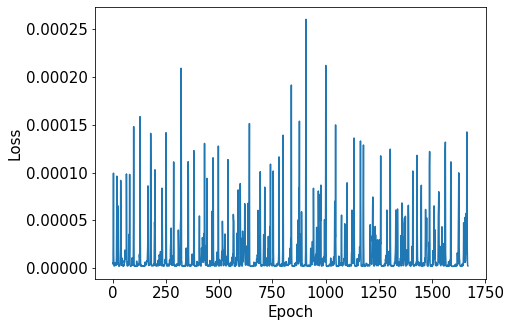

In [85]:
plt.figure()
plt.plot(history);
plt.xlabel('Epoch')
plt.ylabel('Loss')

r = int(len(history)/10)
plt.figure()
plt.plot(history[-r:]);
plt.xlabel('Epoch')
plt.ylabel('Loss')
print('%.3f percent improvement'%(100*(history[0] - history[-1])/history[0]))

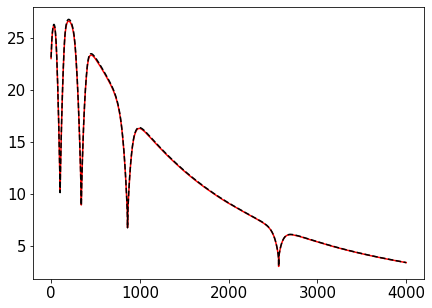

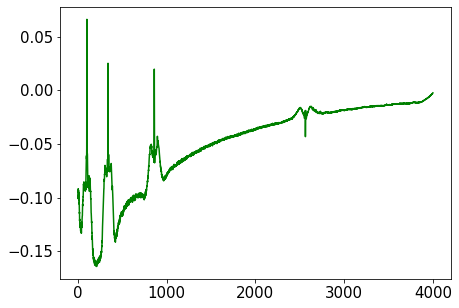

In [86]:
n = np.random.randint(0,len(X))
label = X_scaled[n].reshape(1,-1)
true = np.exp(t[n])
pred = np.exp(msc.inverse_transform(model.predict(label)))[0,:]
plt.plot(true,'k--',zorder=8)
plt.plot(pred,'r-')
plt.figure()
plt.plot(pred-true,'g-')

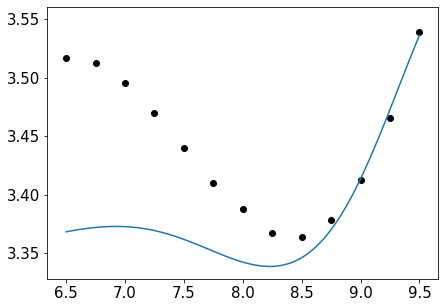

In [90]:
pixel = 2563
temp = 15000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = np.exp(t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = np.exp(msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(linls,lintflux)

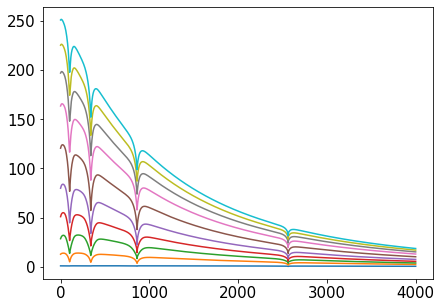

In [459]:
n = 10
ls = np.linspace(8,8,n)
ts = np.linspace(6000,50000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

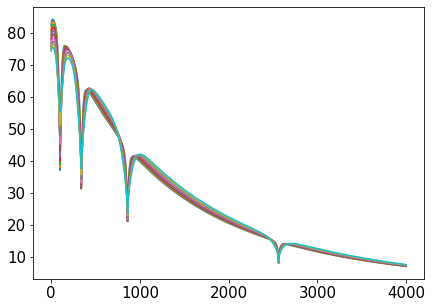

In [432]:
n = 10
ls = np.linspace(6.5,9.5,n)
ts = np.linspace(25000,25000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

In [460]:
def ch_cont(array):
    spec = array
    lamgrid = np.linspace(4000,8000,4000)
    p = np.polynomial.chebyshev.chebfit(lamgrid,spec,4)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    plt.plot(contcorr)
    return contcorr

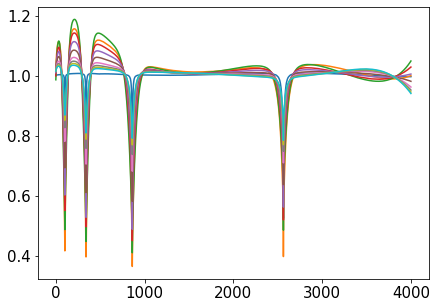

In [461]:
cpreds = [];
diffs = np.repeat(0,4000)
for i in range(len(preds)):
    cpreds.append(ch_cont(preds[i]))
cpreds = np.asarray(cpreds)

In [470]:
contbool = (np.ptp(cpreds,0) < 0.04)

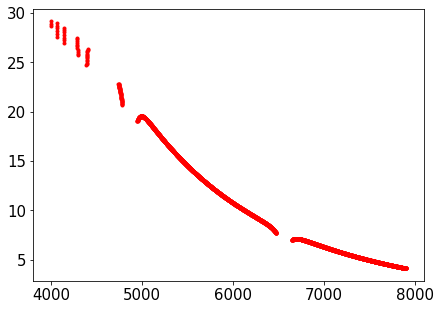

In [479]:
plt.plot(lamgrid[contbool],preds[2][contbool],'r.')